In [43]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [45]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [46]:
data = df['passengers'].values.astype(float)

valid_data_size = 24

train_data = data[:-valid_data_size]
test_data = data[-valid_data_size : ]

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data_norm = scaler.fit_transform(train_data.reshape(-1,1))

In [59]:
seq_len = 12

def make_sequence(input_data, seq):
    train_x = []
    train_y = []
    L = len(input_data)
    
    for i in range(L-seq):
        train_seq = input_data[i:i+seq]
        train_label = input_data[i+seq : i+seq+1]
        train_x.append(train_seq)
        train_y.append(train_label)
    return train_x, train_y


In [49]:
train_x, train_y = make_sequence(train_data_norm, seq_len)

train_x = torch.Tensor(train_x)
train_y = torch.Tensor(train_y)

In [50]:
train_x.size(), train_y.size()

(torch.Size([114, 6, 1]), torch.Size([114, 1, 1]))

In [51]:
# input size : the number of features in the input
# hidden_layer_size : the number of hidden layers
# output_size : the number of items in the output

class LSTM_VER2(nn.Module):
    def __init__(self, input_size = 1, hidden_layer_size = 4, output_size = 1):
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layer=4)
        
        # self.linear = nn.Linear(hidden_layer_size, output_size)
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_layer_size, 50),
            nn.Linear(50, 30),
            nn.Linear(30, 10),
            nn.Linear(10, 1)
        )
        
        # contain previous hidden state, previous cell state
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), 
                            torch.zeros(1,1, self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) , 1, -1), self.hidden_cell)
        
#         predictions = self.linear(lstm_out.view(len(input_seq), -1))
        
        return self.linear(lstm_out[:,-1,:])
    
class RNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.input_vector = 1
        self.sequence_length = 12
        self.output_vector = 100
        self.num_layers = 4
        
        self.lstm = nn.LSTM(input_size=self.input_vector, hidden_size=self.output_vector, num_layers=self.num_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.output_vector, 50),
            nn.Linear(50, 30),
            nn.Linear(30, 10),
            nn.Linear(10,1)
        )
        
    def forward(self, x):
        output, _ = self.lstm(x) #(hidden, cell) 데이터는 사용하지 않음
        return self.linear(output[:,-1,:])
model = RNN()

In [52]:
#model = LSTM_VER2()
model1 = RNN()

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [54]:
epochs = 200

# for i in range(epochs):
#     model.train()
    
#     optimizer.zero_grad()
    
#     output = model(train_x)
    
#     loss = criterion(output, train_y.view(-1,1))
    
#     loss.backward()
#     optimizer.step()
    
#     if i%25 == 1:
#         print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
for i in range(epochs):
    model.train()
    
    output = model(train_x)
    loss = criterion(output, train_y.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%25 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))
    
    
    

Epoch 0, Loss 0.12835
Epoch 25, Loss 0.05333
Epoch 50, Loss 0.03836
Epoch 75, Loss 0.01763
Epoch 100, Loss 0.01604
Epoch 125, Loss 0.01501
Epoch 150, Loss 0.01224
Epoch 175, Loss 0.00868


In [55]:
valid_data_norm = train_data_norm[-valid_data_size:]
valid_x, _ = make_sequence(valid_data_norm, seq_len)

In [56]:
model.eval()

with torch.no_grad():
    valid_tensor = torch.Tensor(valid_x)
    predict = model(valid_tensor)

predict = predict.data.numpy()
actual_predictions = scaler.inverse_transform(predict)


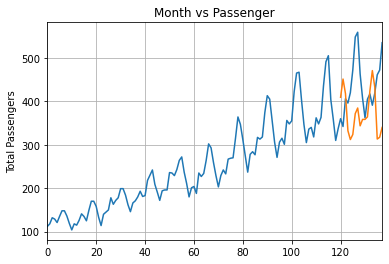

In [58]:
x = np.arange(120,132,1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['passengers'][0:132])
plt.plot(x,actual_predictions)
plt.show()